## Perceptual decision making

### 1. Data generation
$u(t)= \bigg\{ \begin{array}{ll} \bar{u} + \xi (t) & \text{if } 5 \leq t \leq 45 \\  \xi (t) & otherwise \end{array}$

$\bar{u}$ stimulus strength, drawn from a uniformormly from $\pm \frac{3.2}{100} \{1,2,4,8,16\}$ 

$\xi (t)$ is background noise, drawn from a normal distribution with mean 0 and standard deviation 0.03. 

resample for each trial. noise resampled for each time step. 

target $y$ is $sgn(\bar{u})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# #%matplotlib inline

In [50]:
def data(n_trials):
    """
    Generate perceptual decision-making data.
    
    Parameters
    ----------
    n_trials : int
        Number of trials.
    n_time_step : 50
        Number of time steps.
    Returns
    -------
    u : array, shape (n_trials,n_time_step)
        input 
    y : array, shape (n_trials,n_time_step)
        output 
    """
    strength_choices = (3.2/ 100)  * np.array([1,2,4,8,16, -1,-2,-4,-8,-16])
    n_time_step = 75
    time_step= 20 #ms

    u = np.zeros([n_trials,n_time_step])
    y = np.zeros([n_trials,n_time_step])
    
    for trial in range(n_trials):
        strength = np.random.choice(strength_choices)

        for t in range(0,n_time_step):
            if t>=5 and t<=45:
                #noise with std 0.03
                u[trial,t] = strength + np.random.normal(0,0.03)
            else:
                u[trial, t] = np.random.normal(0,0.03)
            
            y[trial, t] = np.sign(strength)
    return u,y

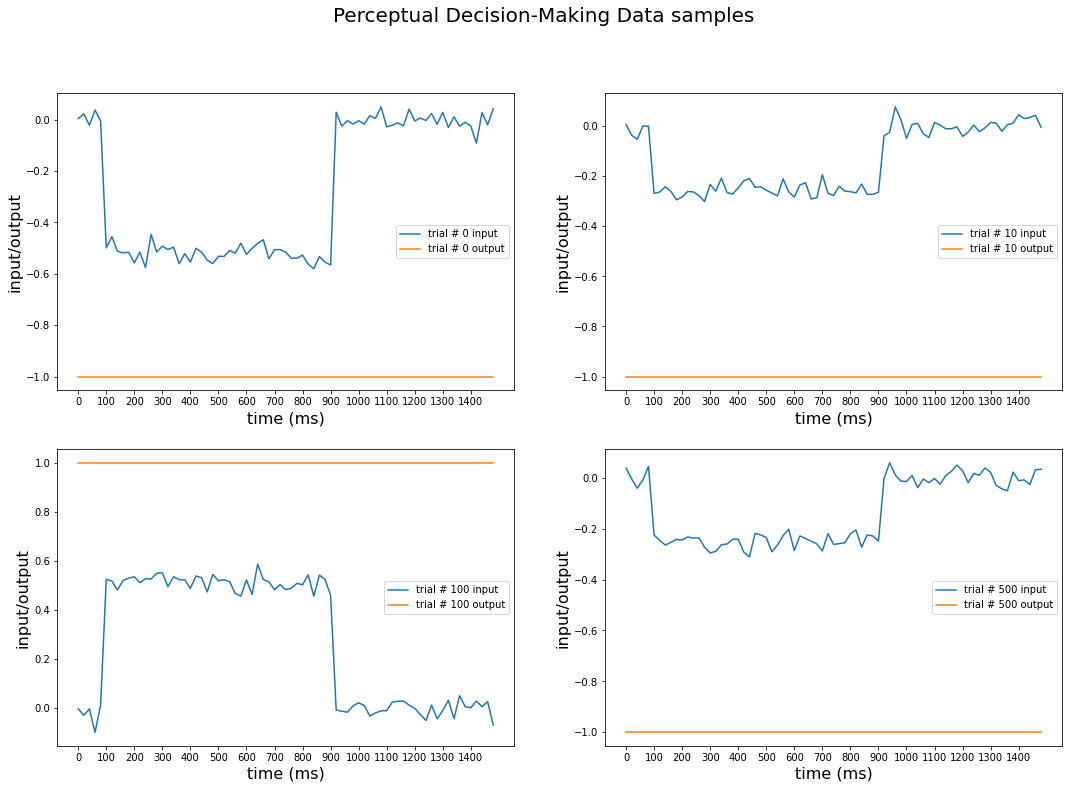

In [51]:
u,y = data(n_trials=1000)
i=0
plt.figure(figsize=(18,12))
plt.suptitle('Perceptual Decision-Making Data samples', fontsize=20)
for trail in [0,10, 100, 500]:
    plt.subplot(2,2,i+1)
    plt.plot(u[trail,:], label='trial # {} input'.format(trail))
    plt.plot(y[trail,:], label='trial # {} output'.format(trail))
    plt.xlabel('time (ms)', fontsize=16)
    #dt = 20ms
    plt.xticks(np.arange(0, 75, step=5), np.arange(0, 1500, step=100))
    plt.ylabel('input/output', fontsize=16)
    plt.legend()
    i+=1

### 2. Recurrent neural network
one dimensional input and output, 

N units in the hidden layer, 

left and right connectivity vector $m, n$ trainable parameters, 

fixed input and output weights $I, W$. 

trainable and fixed weights are drawn from standard normal distribution. 

$\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t)$ 

$\phi(x) = \tanh$ 

$\tau = 100 ms$ 
 
$\Delta t = 20 ms$ 

$J = \frac{1}{N} mn^T$ 

Using forward Euler method to solve the differential equation. 

$x_i(t+ \Delta t) = x_i(t) + \frac{1}{\tau}  \Delta t  \bigg( -x_i(t) + \sum_{j=1}^N J_{ij} \phi(x_j(t)) + I_i u(t) \bigg)$ 



In [88]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,N):
        super(RNN, self).__init__()

        self.hidden_size = N

        # Weight initialization
        self.J = nn.Parameter(torch.randn(self.hidden_size, self.hidden_size)) # Hidden to hidden weight
        self.I = torch.randn(1, self.hidden_size)  # input to hidden weight
        self.w = torch.randn(self.hidden_size, 1)  # hidden to output weight

        # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()

    def forward(self, u):
        x = torch.randn(1, self.hidden_size)  # Initial hidden state
        z= torch.zeros(u.size(0)) # Output 
        for i in range(u.size(0)):
            # Weight update formula
            delta_x = (
                -x
                + torch.matmul(self.activation(x), self.J)
                + torch.matmul(u[i].unsqueeze(1), self.I)
            ) * (self.dt / self.tau)
            x = x + delta_x

            output = torch.matmul(self.activation(x), self.w)
            output = 1/self.hidden_size * output 
            z[i] = output
        return z

In [89]:
model_test = RNN(N=128)

In [90]:
input_test = torch.tensor(u[0,:], dtype=torch.float32)
target_test = torch.tensor(y[0,:], dtype=torch.float32)
# print(input_test.size())
# print(input_test.unsqueeze(1).size())
z = model_test(input_test.unsqueeze(1))
print(z.size())
# print(z[-15:])
# print(target_test[-15:])

torch.Size([75])


### 3. Training
train a network of size $N=128$. batch size 32 trals. and specific lost function is defined as the mean squared error of last $T=15$ time step of each trial:

$loss = \frac{1}{32 * 15} \sum_{i=1}^{32} \sum_{t=45}^{60} (z_i(t) - y_i(t))^2$ 

learning rate $0.05$ , Adam optimizer.

In [ ]:
n_epochs = 1000

mini_batch_size = 32

learning_rate = 5e-3

T=15

model = RNN(N=128)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

u, y = data(n_trials=1000)

for epoch in range(n_epochs):
    for trial in range(u.shape[0]):
        
        input = torch.tensor(u[trial,:], dtype=torch.float32)
        target = torch.tensor(y[trial,:], dtype=torch.float32)

        optimizer.zero_grad()

        output = model(input.unsqueeze(1))

        loss = loss_fn(output[-T:], target[-T:])

        loss.backward()

        optimizer.step()

        if epoch % 100 == 0:
            print("Epoch %d, Loss %f" % (epoch, float(loss)))